##Step 1: Setup Environment
The code installs necessary libraries for machine learning and image processing. It also imports various modules that facilitate data handling, model training, and visualization. Essentially, it sets up the environment for building and evaluating machine learning models, particularly those dealing with images.

In [1]:
!pip install torch torchvision captum datasets

from IPython import get_ipython
from IPython.display import display
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients, LayerGradCam
import cv2

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00


## Step 2: Load Dataset

In [2]:
# Load the Cats vs. Dogs dataset
dataset = load_dataset('pantelism/cats-vs-dogs')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dogs-vs-cats-subset.zip:   0%|          | 0.00/90.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4000 [00:00<?, ? examples/s]

## Step 3: Explore Dataset
This code checks the structure of the dataset and retrieves a sample from the training set. It prints the entire dataset, shows the first sample, and displays the corresponding image path and label, where 0 represents a cat and 1 represents a dog.

In [3]:
# Check the dataset structure
print(dataset)

# View a sample from the training set
print(dataset['train'][0])
print(dataset['train'][0]['image'])
print(dataset['train'][0]['label'])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=490x500 at 0x7FC6D734F820>, 'label': 0}
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=490x500 at 0x7FC6D734FE50>
0


## Step 4: Split Dataset
This code converts the training dataset into a list for easier manipulation. It then splits the data into training and validation sets, allocating 80% for training and 20% for validation. Finally, it prints the sizes of both the training and validation datasets.

In [4]:
# Convert the 'train' dataset to a list for manipulation
train_data = list(dataset['train'])

# Split into train and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Training data size: 3200
Validation data size: 800


## Step 5: Create Custom Dataset Class
This code defines a custom dataset class CatsVsDogsDataset. It initializes with the dataset and optional transformations. The __len__ method returns the dataset size, while the __getitem__ method retrieves an image and its label based on the provided index. It converts the image data to a PIL Image and applies any transformations if specified.

In [5]:
class CatsVsDogsDataset:
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        img_data = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Convert the image data from Hugging Face to a PIL Image
        img = img_data if isinstance(img_data, Image.Image) else Image.fromarray(img_data) if isinstance(img_data, np.ndarray) else Image.open(img_data).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

## Step 6: Define Image Transformations
This code defines a series of image transformations. It resizes images to 224x224 pixels, converts them to tensor format, and normalizes the pixel values using ImageNet statistics. These transformations prepare the images for input into a deep learning model.

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## Step 7: Create DataLoaders
This code creates instances of the custom dataset class for training and validation data, applying the defined transformations. It then initializes DataLoaders for both datasets, specifying a batch size of 32 and shuffling the training data for better randomness. Finally, it prints the lengths of the training and validation DataLoaders, indicating how many batches will be created.

In [7]:
# Create datasets
train_dataset = CatsVsDogsDataset(train_data, transform=transform)
val_dataset = CatsVsDogsDataset(val_data, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train Loader Length: {len(train_loader)}')
print(f'Validation Loader Length: {len(val_loader)}')

Train Loader Length: 100
Validation Loader Length: 25


## Step 8: Train the Model
This code checks for GPU availability and sets the device accordingly. It loads a pre-trained ResNet18 model and modifies its last layer to classify two classes: cat and dog. A cross-entropy loss function and Adam optimizer are defined. The model is then trained over a specified number of epochs. For each epoch, it processes batches of images, calculates the loss, performs backpropagation, and updates the model weights. Finally, it prints the average loss for each epoch and indicates when training is finished.

In [8]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: cat and dog
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust this as needed
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training finished.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Epoch [1/10], Loss: 0.2411
Epoch [2/10], Loss: 0.1416
Epoch [3/10], Loss: 0.1096
Epoch [4/10], Loss: 0.0822
Epoch [5/10], Loss: 0.0685
Epoch [6/10], Loss: 0.0703
Epoch [7/10], Loss: 0.0692
Epoch [8/10], Loss: 0.0946
Epoch [9/10], Loss: 0.0427
Epoch [10/10], Loss: 0.0401
Training finished.


##Step 9: Evaluate the Model
This code defines a function to evaluate the model's performance. It sets the model to evaluation mode and disables gradient calculation to save memory. It iterates through the validation DataLoader, making predictions for each batch of images. The function counts the total number of images and the number of correct predictions. Finally, it calculates and returns the accuracy as a percentage. After defining the function, the model is evaluated on the validation set, and the accuracy is printed.

In [9]:
# Function to evaluate the model
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients for evaluation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total += labels.size(0)  # Count total images
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total  # Calculate accuracy
    return accuracy

# Evaluate the model on the validation set
val_accuracy = evaluate_model(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}%')

Validation Accuracy: 91.12%


## Step 10: Visualize Predictions
This code defines a function to visualize the model's predictions on a sample of images. It sets the model to evaluation mode and retrieves a batch of images and labels from the DataLoader. It then makes predictions without calculating gradients. The function creates a plot displaying the true labels and predicted labels for a specified number of images. Finally, it calls the function to visualize predictions from the validation set, showing how well the model classified the images as cats or dogs.

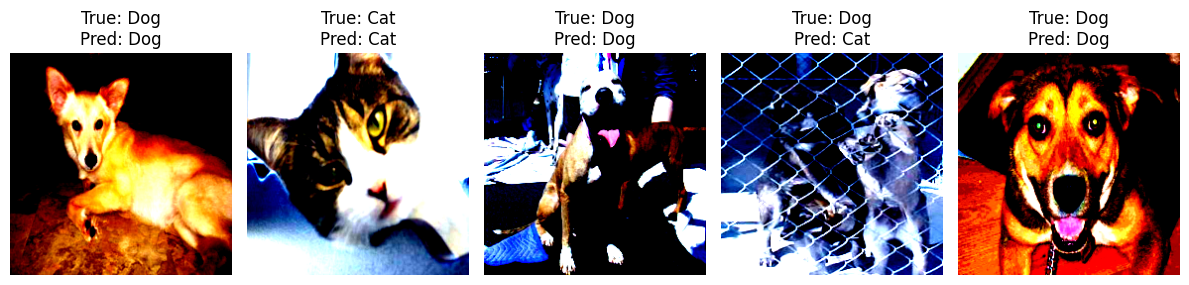

In [10]:
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    # Set up the figure
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())
        plt.title(f"True: {'Dog' if labels[i].item() == 1 else 'Cat'}\nPred: {'Dog' if predicted[i].item() == 1 else 'Cat'}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions from the validation set
visualize_predictions(model, val_loader)

##Step 11: Explain with Integrated Gradients
This code defines a function to compute Integrated Gradients for a given image using the specified model. It sets the model to evaluation mode and initializes the Integrated Gradients method. The input image is prepared by adding a batch dimension and moving it to the appropriate device (GPU or CPU). The function then computes the attributions, which indicate the importance of each pixel in the image for the model's prediction. It returns both the attributions and the convergence delta, which can be useful for assessing the reliability of the attributions.

In [11]:
# Define a function to apply Integrated Gradients
def explain_with_integrated_gradients(model, image):
    model.eval()  # Set model to evaluation mode
    ig = IntegratedGradients(model)
    # Convert image to appropriate format (add batch dimension)
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Get attribution
    attributions, delta = ig.attribute(image, target=1, return_convergence_delta=True)  # Change target if needed

    return attributions, delta


##Step 12: Visualize Attributions
This code defines a function to visualize the attributions computed by the Integrated Gradients method. It first converts the input image tensor to a NumPy array for display. The attributions are processed by squeezing the batch dimension, transposing them to match the image shape, and normalizing their values. The function creates a figure with two subplots: one for the original image and another for the attributions visualized as a heatmap. Finally, the function is called with an example image from the validation dataset, and the computed attributions are visualized alongside the original image.

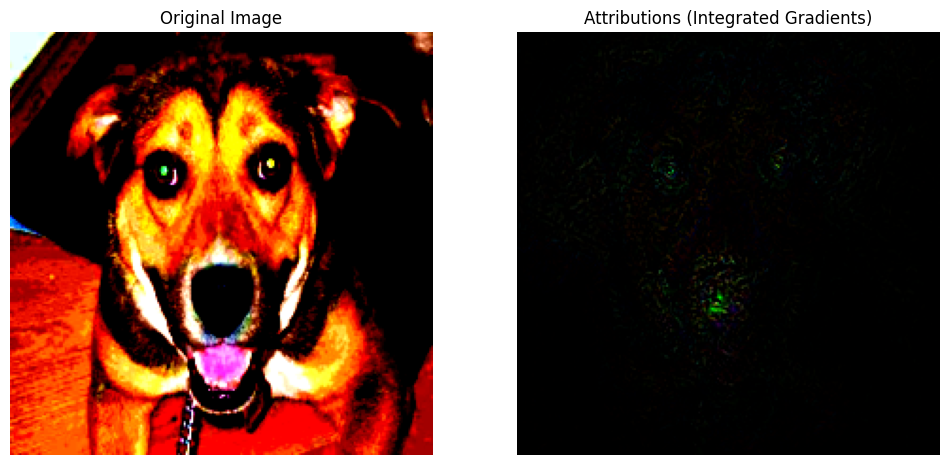

In [16]:
def visualize_attributions(image, attributions):
    # Convert the image tensor to a numpy array and change its shape
    image_np = image.permute(1, 2, 0).cpu().detach().numpy()  # Change shape to (224, 224, 3)

    # Convert attributions to a numpy array and reshape
    attributions = attributions.squeeze().cpu().detach().numpy()  # Remove the batch dimension

    # *** Transpose the attributions to (height, width, channels) ***
    attributions = attributions.transpose(1, 2, 0)  # Change shape to (224, 224, 3)

    attributions = np.clip(attributions, 0, np.max(attributions))  # Clip values
    attributions = (attributions - np.min(attributions)) / (np.max(attributions) - np.min(attributions))  # Normalize

    # Display original image and attributions
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_np)  # Use the reshaped image
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Resize attributions to match the image dimensions (optional)
    attributions_resized = np.clip(attributions, 0, 1)  # Ensure values are in valid range for display
    ax[1].imshow(attributions_resized, cmap='hot')  # Using a heatmap color map
    ax[1].set_title('Attributions (Integrated Gradients)')
    ax[1].axis('off')

    plt.show()

image, _ = val_dataset[4]
attributions, _ = explain_with_integrated_gradients(model, image)
visualize_attributions(image, attributions)


##Step 13: Explain with Grad-CAM
This code defines a function to compute the Grad-CAM (Gradient-weighted Class Activation Mapping) heatmap for a given image using the specified model. The function begins by setting the model to evaluation mode and initializing the LayerGradCam object with the model and a specific layer (layer4 for ResNet). It moves the input image to the same device as the model. The function then generates a heatmap by passing the image (with a batch dimension added) to the LayerGradCam object. The heatmap is processed by squeezing it, applying ReLU to retain only positive values, and normalizing it to the range [0, 1]. The resulting heatmap can be used to visualize the regions of the image that most influenced the model's prediction.

In [13]:
# Define the Grad-CAM function
def explain_with_grad_cam(model, image):
    model.eval()  # Set model to evaluation mode
    layer_grad_cam = LayerGradCam(model, model.layer4)  # Use layer4 for ResNet

    # *** Move the image to the same device as the model ***
    image = image.to(next(model.parameters()).device) # move to the device

    # Get the heatmap for the predicted class
    heatmap = layer_grad_cam.attribute(image.unsqueeze(0), target=1)  # Change target if needed

    # Normalize the heatmap
    heatmap = heatmap.squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize to [0, 1]

    return heatmap

## Step 14: Visualize Comparison of Attributions
This code defines a function to visualize and compare attributions generated by Integrated Gradients and Grad-CAM methods. It starts by converting the input image tensor to a NumPy array. Then, it processes the attributions from Integrated Gradients by squeezing, transposing, clipping, and normalizing them. For the Grad-CAM attributions, it reshapes and resizes them to match the dimensions of the original image, also applying clipping and normalization. The function creates a figure with three subplots: one for the original image and one each for the attributions from the two methods. Finally, it displays the figure, allowing for a visual comparison of the different attribution methods.

In [14]:
def visualize_comparison(image, ig_attributions, grad_cam_attributions):
    # Convert the image tensor to a numpy array and change its shape
    image_np = image.permute(1, 2, 0).cpu().detach().numpy()  # Change shape to (224, 224, 3)

    # Convert Integrated Gradients attributions to a numpy array and reshape
    ig_attributions = ig_attributions.squeeze().cpu().detach().numpy()
    ig_attributions = ig_attributions.transpose(1, 2, 0)  # Change shape to (224, 224, 3)

    # Clip and normalize Integrated Gradients attributions
    ig_attributions = np.clip(ig_attributions, 0, np.max(ig_attributions))
    ig_attributions = (ig_attributions - np.min(ig_attributions)) / (np.max(ig_attributions) - np.min(ig_attributions))

    # Convert Grad-CAM attributions to a numpy array and reshape
    grad_cam_attributions = grad_cam_attributions.squeeze()

    # Reshape Grad-CAM attributions to (height, width) for grayscale
    grad_cam_attributions = grad_cam_attributions.reshape(grad_cam_attributions.shape[0], grad_cam_attributions.shape[1])

    # Resize Grad-CAM attributions to match the image dimensions using INTER_LINEAR
    grad_cam_attributions = cv2.resize(grad_cam_attributions, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Clip and normalize Grad-CAM attributions
    grad_cam_attributions = np.clip(grad_cam_attributions, 0, np.max(grad_cam_attributions))
    grad_cam_attributions = (grad_cam_attributions - np.min(grad_cam_attributions)) / (np.max(grad_cam_attributions) - np.min(grad_cam_attributions))


    # Display original image and attributions from both methods
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(image_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(ig_attributions, cmap='hot')  # Using a heatmap color map
    ax[1].set_title('Attributions (Integrated Gradients)')
    ax[1].axis('off')

    ax[2].imshow(grad_cam_attributions, cmap='hot')  # Using a heatmap color map
    ax[2].set_title('Attributions (Grad-CAM)')
    ax[2].axis('off')

    plt.show()

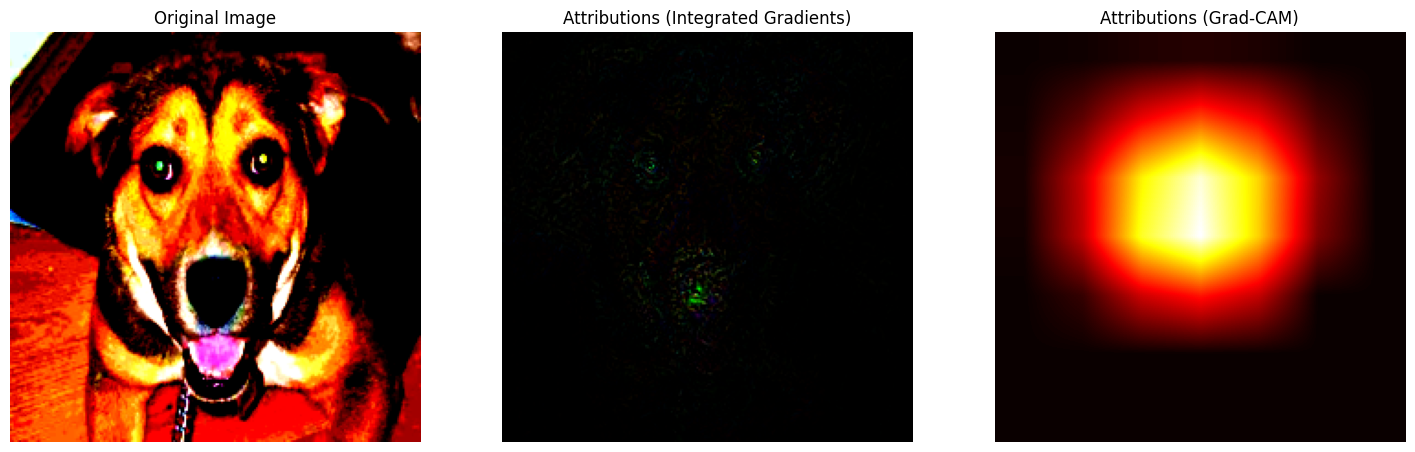

In [20]:
# Get a sample from the validation set
image, _ = val_dataset[4]  # Change index as needed

# Get attributions from both methods
ig_attributions, _ = explain_with_integrated_gradients(model, image)
grad_cam_attributions = explain_with_grad_cam(model, image)

# Visualize the comparison
visualize_comparison(image, ig_attributions, grad_cam_attributions)

## Conclusion
In this notebook, we implemented two popular explainability techniques—Integrated Gradients and Grad-CAM—using PyTorch and Captum. Both methods help us understand the model's decision-making process by highlighting the parts of the input image that contribute most to the classification. Such insights are essential in validating the model's predictions and building trust in AI systems.